In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import seaborn as sns

In [2]:
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.
C:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tenso

In [4]:
train = pd.read_csv('stage_1_train.csv')

In [5]:
print(len(train))

4045572


In [6]:
train_copy = train.copy()

In [7]:
train.head(20)

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0
6,ID_2669954a7_epidural,0
7,ID_2669954a7_intraparenchymal,0
8,ID_2669954a7_intraventricular,0
9,ID_2669954a7_subarachnoid,0


In [8]:
train.Label.isnull().sum()

0

In [10]:
train_images_dir = 'stage_1_train_images/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]

In [11]:
test_images_dir = 'stage_1_test_images/'
test_images = [ f for f in listdir(test_images_dir) if isfile(join(test_images_dir,f))]

In [12]:
# train_images[:5]
test_images[:5]

['ID_000012eaf.dcm',
 'ID_0000ca2f6.dcm',
 'ID_000259ccf.dcm',
 'ID_0002d438a.dcm',
 'ID_00032d440.dcm']

In [13]:
print("No. of Train Images : ", len(train_images))
print("No. of Test Images : ", len(test_images))

No. of Train Images :  220217
No. of Test Images :  78545


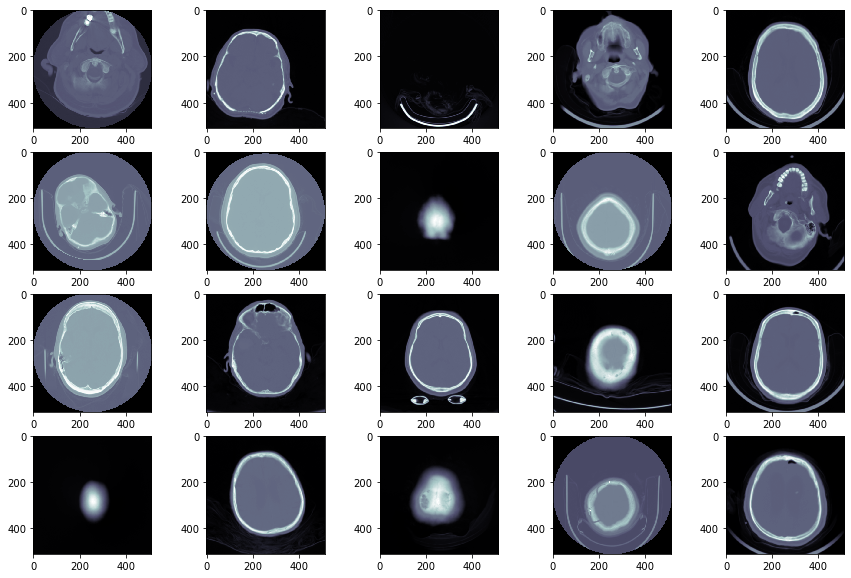

In [14]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [ ]:
print(ds)

In [15]:
im = ds.pixel_array
print('Type of im : ', type(im))
print('DataType of im : ', im.dtype)
print('Shape of im : ', im.shape)

Type of im :  <class 'numpy.ndarray'>
DataType of im :  uint16
Shape of im :  (512, 512)


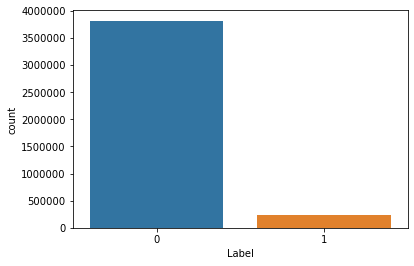

In [16]:
sns.countplot(train.Label)

In [17]:
train.Label.value_counts()

0    3814760
1     230812
Name: Label, dtype: int64

In [18]:
train.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [19]:
train.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [20]:
train['Subtype'] = train['ID'].str.rsplit('_', 1, expand=True)[1]
train['ID'] = train['ID'].str.rsplit('_', 1, expand=True)[0]

In [21]:
train.head()

,ID,Label,Subtype
0,ID_63eb1e259,0,epidural
1,ID_63eb1e259,0,intraparenchymal
2,ID_63eb1e259,0,intraventricular
3,ID_63eb1e259,0,subarachnoid
4,ID_63eb1e259,0,subdural


To use our dataloader we need to turn our traindf into something more useful. For this purpose we need to have the image id in one column and the subtypes of hemorrhage in further individual columns.

In [22]:
train = pd.pivot_table(train, index="ID", columns="Subtype", values="Label" )
train.head()

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


test_data 

In [24]:
test = pd.read_csv('stage_1_sample_submission.csv')
test.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


In [25]:
test['Subtype'] = test['ID'].str.rsplit('_', 1, expand=True)[1]
test['ID'] = test['ID'].str.rsplit('_', 1, expand=True)[0]
test.head()

,ID,Label,Subtype
0,ID_28fbab7eb,0.5,epidural
1,ID_28fbab7eb,0.5,intraparenchymal
2,ID_28fbab7eb,0.5,intraventricular
3,ID_28fbab7eb,0.5,subarachnoid
4,ID_28fbab7eb,0.5,subdural


In [26]:
test = pd.pivot_table(test, index="ID", columns="Subtype", values="Label")
test.head()

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_000012eaf,0.5,0.5,0.5,0.5,0.5,0.5
ID_0000ca2f6,0.5,0.5,0.5,0.5,0.5,0.5
ID_000259ccf,0.5,0.5,0.5,0.5,0.5,0.5
ID_0002d438a,0.5,0.5,0.5,0.5,0.5,0.5
ID_00032d440,0.5,0.5,0.5,0.5,0.5,0.5


****Vgg16 Model Architecture

In [27]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split

In [28]:
# There are two classes hemorrhage or non_hemorrhage
num_classes = 1

In [29]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu",input_shape=(512,512,1)))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 256)     295168    
__________

In [31]:
train_copy.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


**Healthy Patient & Diagnosed Patients**

In [32]:
train.head()

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


In [33]:
train.index.values[-1]

'ID_fffff9393'

In [34]:
sick_patients = train[train["any"]==1].index.values
len(sick_patients)

97103

In [35]:
seed = 1
healthy_patients = train[ train["any"] == 0 ].index.values
healthy_patients_selection = np.random.RandomState(seed).choice(
    healthy_patients, size=len(sick_patients), replace=False
)
len(healthy_patients_selection)

97103

In [36]:
selected_patients = list(set(healthy_patients_selection).union(set(sick_patients)))
len(selected_patients)

194206

In [37]:
selected_patients

['ID_ae528ef40',
 'ID_bb1b05b39',
 'ID_8c20bfb09',
 'ID_f93f790d9',
 'ID_579b76af8',
 'ID_818813e81',
 'ID_a1d10cf74',
 'ID_5df1dd43e',
 'ID_30e4b8f24',
 'ID_a813e5c21',
 'ID_8020da13c',
 'ID_7fa9d739b',
 'ID_cc77b6178',
 'ID_48c2a441e',
 'ID_74d4aee25',
 'ID_656ab1df8',
 'ID_88df80989',
 'ID_93397daea',
 'ID_6c7a636ce',
 'ID_2785ae270',
 'ID_ea352bcd8',
 'ID_7e51db507',
 'ID_f1e50be6f',
 'ID_319a2a477',
 'ID_d0a01aab6',
 'ID_8b356e1b1',
 'ID_bb3340433',
 'ID_c038bd2a1',
 'ID_673a308f3',
 'ID_a773ceced',
 'ID_5c9b83c6c',
 'ID_f20a11e4c',
 'ID_936154a40',
 'ID_38867ad3c',
 'ID_6c04db163',
 'ID_f924996b3',
 'ID_69446544c',
 'ID_a8fdf8ac3',
 'ID_8c1d7a2d6',
 'ID_69e58e9a7',
 'ID_06ffcdfc4',
 'ID_5ba990803',
 'ID_df3c4bfae',
 'ID_922f868ec',
 'ID_0b1beccde',
 'ID_ffaf68259',
 'ID_a198d7359',
 'ID_97c76fd5e',
 'ID_4e03959a5',
 'ID_8672abaab',
 'ID_bf3f06f40',
 'ID_8cd6aa68c',
 'ID_44cb4ddae',
 'ID_322599ec7',
 'ID_cdabf654d',
 'ID_9e54c58fd',
 'ID_b73d17e80',
 'ID_cdae284cb',
 'ID_e6a277502

In [38]:
updated_train = train.loc[selected_patients].copy()
# updated_train.head()
updated_train["any"].value_counts()

1    97103
0    97103
Name: any, dtype: int64

In [39]:
updated_train.values

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [40]:
split_seed = 1
train_data, test_data = train_test_split(updated_train,
                                        test_size=0.3,
                                        stratify=updated_train.values,
                                        random_state=split_seed)
print(train_data.shape)
print(test_data.shape)

(135944, 6)
(58262, 6)


In [41]:
train_data.shape

(135944, 6)

In [47]:
def window_img(dcm, width=None, level=None, norm=True):
    pixels = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Pad non-square images
    if pixels.shape[0] != pixels.shape[1]:
        (a,b) = pixels.shape
        if a > b:
            padding = ((0, 0), ((a-b) // 2, (a-b) // 2))
        else:
            padding = (((b-a) // 2, (b-a) // 2), (0, 0))
        pixels = np.pad(pixels, padding, mode='constant', constant_values=0)
            
    if not width:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]
    if not level:
        level = dcm.WindowCenter
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]
    lower = level - (width / 2)
    upper = level + (width / 2)
    img = np.clip(pixels, lower, upper)
    
    if norm:
        return (img - lower) / (upper - lower)
    else:
        return img

In [42]:
train_data.index[1]

'ID_0e54d2e09'

In [43]:
train_data.head()

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_97e8ec477,0,0,0,0,0,0
ID_0e54d2e09,1,0,0,1,1,0
ID_1a5ff27e1,1,1,1,0,0,0
ID_2c98e2dc7,1,0,0,0,0,1
ID_f05ba573d,0,0,0,0,0,0


In [44]:
train_data.iloc[1:2,0]

ID
ID_0e54d2e09    1
Name: any, dtype: int64

In [45]:
print(len(train_data)/8)

16993.0


In [49]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
    
Xtrain_data_model = []
Ytrain_data_model = []
for i in range(1, int(round(len(train_data)/2000))):
    dcm = pydicom.dcmread(train_images_dir + train_data.index.values[i] + '.dcm')
    img = window_img(dcm, width=200, level=30, norm=True)
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img, cmap=plt.cm.bone)
#     fig.add_subplot
    Xtrain_data_model.append(img)
    Ytrain_data_model.append(train_data.iloc[i:i+1, 0])


FileNotFoundError: [Errno 2] No such file or directory: 'stage_1_train_images/ID_f05ba573d.dcm'

<Figure size 1080x720 with 0 Axes>

In [ ]:

print(Xtrain_data_model[0])
print(Ytrain_data_model[0])

In [ ]:
train_data.sum()

In [ ]:
train_data.shape

In [ ]:
pos_perc_train = train_data.sum() / train_data.shape[0] * 100
pos_perc_dev = test_data.sum() / test_data.shape[0] * 100


fig, ax = plt.subplots(2,1,figsize=(20,14))
sns.barplot(x=pos_perc_train.index, y=pos_perc_train.values, palette="Set2", ax=ax[0]);
ax[0].set_title("Target distribution used for training data")
sns.barplot(x=pos_perc_dev.index, y=pos_perc_dev.values, palette="Set2", ax=ax[1]);
ax[1].set_title("Target distribution used for dev data");

In [ ]:
img1 = pydicom.dcmread(train_images_dir+train_images[5])
# print(img1)
# plt.imshow(img1.pixel_array, cmap=plt.cm.bone)
# print(len(train_images))
img2 = window_img(img1, 200, 30)

plt.imshow(img2, cmap=plt.cm.bone)
# type(img2)
print(img2.shape)

In [ ]:
train.head()

In [ ]:
train.iloc[1,:]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(train, train['any'], test_size=0.33, random_state=42)

In [ ]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
X_train = np.asarray(Xtrain_data_model)
Y_train = np.asarray(Ytrain_data_model)
print(X_train.shape[0])

In [ ]:
X_train = X_train.reshape((X_train.shape[0],512,512, 1))
print(X_train.shape)
print(Y_train.shape)

In [ ]:
model.summary()

In [ ]:

model.fit(X_train,Y_train,
          epochs=1)